In [1]:
# Reference: https://colab.research.google.com/drive/19dGKong-LraUG3wYlJuPCquemJ13NN8R#scrollTo=dkU6eM05Yx1V

!pip install -U git+https://github.com/faustomorales/keras-ocr.git #egg=keras-ocr
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-req-build-r4c0c3tw
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-req-build-r4c0c3tw
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Connect Google Drive**

In [2]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/Colab Notebooks/RZ/Demo Day/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Module**

In [3]:
import zipfile
import datetime
import string
import glob
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

**Generating Synthetic Data**

In [4]:
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for drive/My Drive/Colab Notebooks/RZ/Demo Day/keras-ocr/fonts.zip
Unzipping fonts ZIP file.


Filtering fonts.: 100%|██████████| 2746/2746 [00:46<00:00, 59.29it/s]


Looking for drive/My Drive/Colab Notebooks/RZ/Demo Day/keras-ocr/backgrounds.zip


**Build Data Generator**

The first generated text is: Caused lakes treated as
The first generated validation image (below) contains: 1
88
5
1962 in
di
cate of s


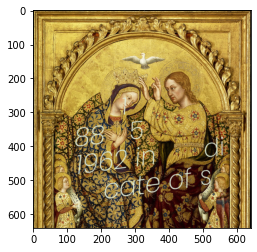

In [5]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
# Minor bug fix manually: https://github.com/faustomorales/keras-ocr/issues/103 
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

**Build Detector and Recognizer Model**

In [10]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan',
    # include_top=False # Fix with latest update: https://github.com/faustomorales/keras-ocr/issues/66
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


**Train Text Detector**

In [ ]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit_generator(
    generator=detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_ocr/tools.py:580: RuntimeWarning: invalid value encountered in float_scalars
  rotation = np.arctan((tl[0] - bl[0]) / (tl[1] - bl[1]))


Epoch 1/1000
 14/827 [..............................] - ETA: 5:01:22 - loss: 0.0104

**Train The Recognizer**

In [ ]:
max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

**Converting Image Generator into a `batch_generator`**

In [ ]:
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=True
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    epochs=1000,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
      tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
      tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
      tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0
)

**Recognize to Extract The Text**

In [ ]:
pipeline = keras_ocr.pipelines.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions])
plt.imshow(drawn)

In [ ]:
# !curl https://i.postimg.cc/BZ7JfvzV/00043445-00043449.png --output 00043445-00043449.png
image = keras_ocr.tools.read('test_image.jpg')
boxes = detector.detect(images=[image])[0]
drawn = keras_ocr.detection.drawBoxes(image=image, boxes=boxes)
plt.imshow(drawn)